In [ ]:
import keras

# 사전 훈련된 EfficientNetB0 모델 불러오기 (최상단 분류층은 제외)
base_model = keras.applications.EfficientNetB0(include_top=False)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
from keras.utils import image_dataset_from_directory

# 폴더에서 이미지를 불러와서 훈련/검증 데이터셋으로 나눈다
# - validation_split=0.2: 전체 데이터의 20%를 검증용으로 사용
# - subset='both': 훈련(train)과 검증(validation) 데이터를 동시에 반환
# - image_size=(224, 224): 이미지를 모델 입력 크기에 맞게 리사이즈
# - seed=42: 동일한 분할을 위해 시드 고정 (수업에서만 사용)
train_ds, val_ds = image_dataset_from_directory(
    "../ex_images/Pistachio_Image_Dataset", image_size=(224, 224),
    validation_split=0.2, subset='both', seed=42
)

Found 2148 files belonging to 2 classes.
Using 1719 files for training.
Using 429 files for validation.


In [9]:
# 기존에 학습된 EfficientNetB0의 가중치를 고정 (미세조정하지 않음)
# 즉, 이 층들의 weight는 훈련 중에 변경되지 않음
base_model.trainable=False

# 입력층 정의 필수 (이미지 크기 224x224, 컬러 채널)
inputs = keras.layers.Input(shape=(224, 224, 3))

# 입력을 EfficientNetB0 모델에 통과시킴 (특징 추출만 수행)
x = base_model(inputs)

# 출력 특성맵을 전역 평균 풀링으로 1차원 벡터로 변환 (따로 Stride 필요 X)
# - Flatten 대신 사용되며, 공간 정보를 평균으로 요약
x = keras.layers.GlobalAveragePooling2D()(x)

# 밀집층
x = keras.layers.Dense(128, activation='relu')(x)

# 출력층 - 이진분류 문제이기 때문에 sigmoid
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# 모델 생성
model = keras.Model(inputs, outputs)

In [11]:
# Adam 학습률 정의
adam = keras.optimizers.Adam(learning_rate=0.001)

# 컴파일 설정
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hist = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 323ms/step - accuracy: 0.8030 - loss: 0.3753 - val_accuracy: 0.9720 - val_loss: 0.1016
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.9619 - loss: 0.1037 - val_accuracy: 0.9767 - val_loss: 0.0761
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.9842 - loss: 0.0659 - val_accuracy: 0.9720 - val_loss: 0.0678
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step - accuracy: 0.9875 - loss: 0.0456 - val_accuracy: 0.9790 - val_loss: 0.0545
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.9863 - loss: 0.0403 - val_accuracy: 0.9814 - val_loss: 0.0483
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.9923 - loss: 0.0301 - val_accuracy: 0.9790 - val_loss: 0.0600
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - accuracy: 0.9799 - loss: 0.0434 - val_accuracy: 0.9790 - val_loss: 0.0559
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.9952 - loss: 0.0191 - val_accu

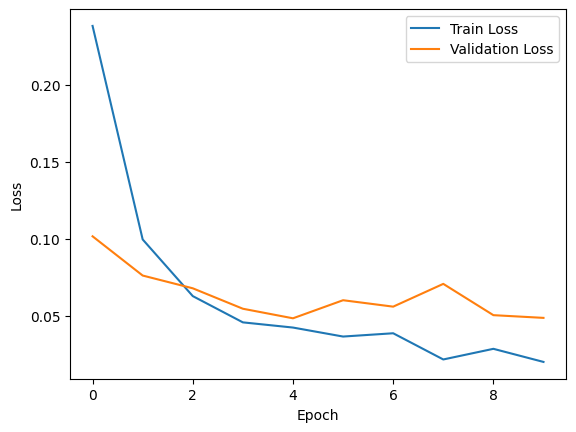

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
model2 = keras.models.load_model("best-model.keras")

model2.evaluate(val_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.9831 - loss: 0.0454


[0.04827484115958214, 0.9813519716262817]

In [16]:
import numpy as np
from PIL import Image
img = Image.open("../ex_images/Pistachio_Image_Dataset/Siirt_Pistachio/siirt (1).jpg")
img = np.array(img.resize((224, 224)))
img.shape

(224, 224, 3)

In [17]:
img = img[np.newaxis, :]
img.shape

(1, 224, 224, 3)

In [18]:
model2.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


array([[0.9723153]], dtype=float32)